In [1]:
from monodromy.haar import expected_cost, coverage_to_approx_haar
from qiskit.circuit.library import iSwapGate
from monodromy.render import gates_to_coverage_plot
from monodromy.haar import expected_cost
from monodromy.coverage import coverage_lookup_cost
from qiskit.extensions import UnitaryGate
from weylchamber import canonical_gate

# %matplotlib widget

In [2]:
5.76e-3 + 1.909e-3

0.0076690000000000005

In [3]:
import numpy as np

np.pi / 4

0.7853981633974483

In [4]:
# define fidelity model as function of (time) cost
class ErrorModel:
    """Use affine error model [1], which relates linearly fidelity to execution time.
    Ref:
    [1] https://quantum-journal.org/papers/q-2022-04-27-696/
    """

    def __init__(self, unit_fidelity=0.995):
        """Unit fidelity is the fidelity of operation with unit cost 1.0

        NOTE: simple convention is that CX, iSWAP have unit cost 1.0, then
        sqrt(CX) and sqrt(iSWAP) have unit cost 0.5, etc.
        """
        assert 0 <= unit_fidelity and unit_fidelity <= 1
        self.unit_fidelity = unit_fidelity

    def fidelity(self, cost):
        return (self.unit_fidelity - 1) * cost + 1

    def infidelity(self, cost):
        return 1 - self.fidelity(cost)


affine_error_model = ErrorModel()

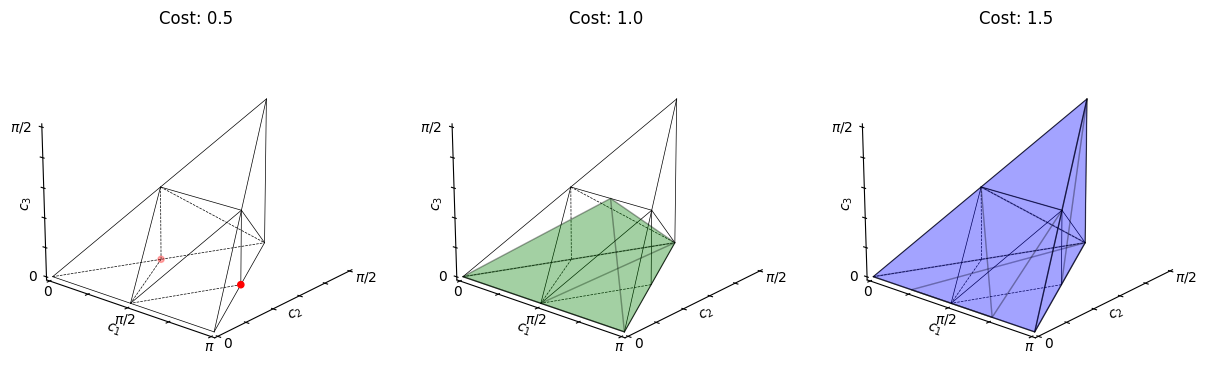

1.1049413181578387


In [5]:
coverage = gates_to_coverage_plot(iSwapGate().power(1 / 2), costs=[0.5])
print(expected_cost(coverage))

In [6]:
target = UnitaryGate(canonical_gate(0.5, 0.25, 0.26))
coverage_lookup_cost(coverage, target)
# target_build_ansatz(coverage, target, approx_degree=0.1).draw("mpl")

1.5

In [7]:
target = UnitaryGate(canonical_gate(0.5, 0.25, 0.26))
coverage_lookup_cost(coverage, target, affine_error_model)
# target_build_ansatz(coverage, target, approx_degree=0.1).draw("mpl")

1.0

In [8]:
coverage_to_approx_haar(coverage, affine_error_model)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


1.15

Cost of unitary is 1.0


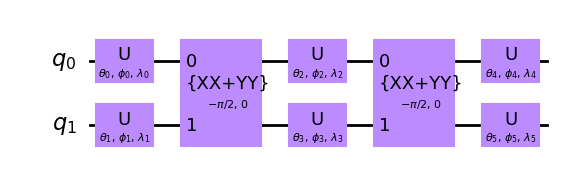

In [ ]:
target_build_ansatz(coverage, target).draw("mpl")

In [ ]:
# target = UnitaryGate(canonical_gate(0.5, 0.25, 0.26))
# print(coverage_lookup_cost(coverage_1, target))
# print(coverage_lookup_cost(coverage_1, target, affine_error_model))
# target = UnitaryGate(canonical_gate(0.5, 0.5, 0.5))
# print(coverage_lookup_cost(coverage_1, target))
# print(coverage_lookup_cost(coverage_1, target, affine_error_model))

In [ ]:
# """scripts/approx_gateset.py.

# Example script showing how to optimize a(n XX-based) gateset for performance
# against a user-defined cost metric.  This version of the script performs Monte
# Carlo sampling of unitaries from the Haar distribution, which lets us analyze
# non-exact decomposition techniques, like approximation and mirroring.

# NOTE: The optimization loop requires `pybobyqa`, a derivative-free optimizer.

# NOTE: `rescaled_objective` always includes a full XX.
# """

# import math
# import warnings
# from itertools import count
# from time import perf_counter

# import numpy as np
# import pybobyqa
# import qiskit
# from qiskit.quantum_info.synthesis.xx_decompose import XXDecomposer
# from scipy.stats import unitary_group

# gateset_dimension = 2  # how many gates to include beyond a full CX
# filename = "approx_gateset_landscape_2d_mirror.dat"  # .dat file with expected cost info
# approximate = True
# mirror = True

# print(
#     f"Gateset dim: {gateset_dimension}, "
#     f"approximate: {approximate}, "
#     f"mirror: {mirror}"
# )

# #
# # ERROR MODEL
# #
# # We assume that the infidelity cost of a native 2Q interaction is affinely
# # related to the interaction strength.  The following two values track the
# # offset and the slope of this affine-linear function.
# #
# # first summand: 2Q invocation cost; second summand: cost of local gates
# offset = 909 / (10000 * 100) + 1 / 1000
# # note: Isaac reports this value in percent per degree
# scale_factor = (64 * 90) / (10000 * 100)


# def operation_cost(
#     strength,
#     scale_factor: float = scale_factor,
#     offset: float = offset,
# ):
#     return strength * scale_factor + offset


# # useful for reproducibility
# np.random.seed(0)

# # tuples of descending strengths in [0, 1]
# #     -> {"average_cost", "average_overshot", "sigma_cost", "sigma_overshot"}
# cost_table = {}


# def extract_cost(circuit, basis_infidelity):
#     execution_infidelity = 0
#     for g, q, _ in circuit.data:
#         if len(q) < 2:
#             continue
#         if isinstance(g, qiskit.circuit.library.CXGate):
#             execution_infidelity += basis_infidelity[np.pi / 2]
#         elif isinstance(g, qiskit.circuit.library.RZXGate):
#             execution_infidelity += basis_infidelity[g.params[0]]
#         else:
#             warnings.warn(f"Unknown 2Q gate: {g}")

#     return execution_infidelity


# def single_circuit_infidelity(decomposer, u, basis_infidelity, approximate=True):
#     basis_fidelity = {k: 1 - v for k, v in basis_infidelity.items()}
#     circuit = decomposer(u, basis_fidelity=basis_fidelity, approximate=approximate)
#     execution_infidelity = extract_cost(circuit, basis_infidelity)
#     model_matrix = qiskit.quantum_info.operators.Operator(circuit).data
#     model_infidelity = 1 - 1 / 20 * (
#         4 + abs(np.trace(np.conj(np.transpose(u)) @ model_matrix)) ** 2
#     )
#     return model_infidelity + execution_infidelity


# def single_sample_infidelity(
#     decomposer, basis_infidelity, mirror=mirror, approximate=approximate
# ):
#     u = unitary_group.rvs(4)
#     u = u / (np.linalg.det(u) ** (1 / 4))
#     infidelity = single_circuit_infidelity(
#         decomposer, u, basis_infidelity, approximate=approximate
#     )

#     if mirror:
#         v = u @ qiskit.circuit.library.SwapGate().to_matrix()
#         mirror_infidelity = single_circuit_infidelity(
#             decomposer, v, basis_infidelity, approximate=approximate
#         )
#         infidelity = min(infidelity, mirror_infidelity)

#     return infidelity


# def objective(ratios, attempts=10_000):
#     global cost_table

#     decomposer = XXDecomposer(euler_basis="PSX")
#     basis_infidelity = {np.pi / 2 * ratio: operation_cost(ratio) for ratio in ratios}

#     timer = perf_counter()
#     infidelity = 0
#     for _ in range(attempts):
#         infidelity += single_sample_infidelity(decomposer, basis_infidelity)
#     infidelity /= attempts
#     print(
#         f"Analyzing {ratios} -> {infidelity} "
#         f"took {perf_counter() - timer:.5f} seconds."
#     )

#     cost_table[tuple(ratios)] = {"average_cost": infidelity}

#     return infidelity


# def rescaled_objective(ratios):
#     """`objective` with its domain rescaled for easier use by `pybobyqa`: the
#     sequence.

#         [a1, a2, ..., an]

#     is forwarded to `objective` as

#         [b1, b2, ..., bn] = [a1, a1 * a2, ..., a1 * a2 * ... an],

#     so that 0 <= a1, a2, ..., an <= 1 implies b1 >= b2 >= ... >= bn.
#     """
#     triangular_strengths = []
#     for ratio in [1, *ratios]:  # automatically include a full CX
#         if 0 < len(triangular_strengths):
#             previous_strength = triangular_strengths[-1]
#         else:
#             previous_strength = 1
#         triangular_strengths.append(previous_strength * ratio)

#     return objective(triangular_strengths)


# def print_cost_table():
#     """Utility function for printing the expected costs calculated so far."""
#     global filename, gateset_dimension

#     keys = ["average_cost"]

#     print("Dumping cost table...")
#     with open(filename, "w") as fh:
#         fh.write(
#             " ".join([f"strength{n}" for n in range(1 + gateset_dimension)])
#             + " "
#             + " ".join(keys)
#             + "\n"
#         )
#         for k, v in cost_table.items():
#             fh.write(
#                 " ".join(str(float(entry)) for entry in k)
#                 + " "
#                 + " ".join(str(v[key]) for key in keys)
#                 + "\n"
#             )
#     print("Dumped.")


# ################################################################################

# # make the best use of time by first using `pybobyqa` to calculate an optimal
# # gateset.
# x0 = np.array([1 / 2] * gateset_dimension)
# solution = pybobyqa.solve(
#     rescaled_objective,
#     x0,
#     bounds=([0] * gateset_dimension, [1] * gateset_dimension),
#     objfun_has_noise=False,
#     print_progress=True,
#     rhoend=1e-4,
# )

# print("Optimizer solution:")
# print(solution)

# print(cost_table)


# ################################################################################

# print(
#     "Now we enter an infinite loop to flesh out the gateset landscape and "
#     "turn it into a nice plot overall.  Use KeyboardInterrupt to quit "
#     "whenever you're satisfied."
# )


# def iterate_over_total(total, bucket_count, fn, partial_fill=None):
#     partial_fill = partial_fill if partial_fill is not None else []
#     if bucket_count == len(partial_fill):
#         return fn(partial_fill)

#     if bucket_count == 1 + len(partial_fill):
#         if total - sum(partial_fill) >= 2:
#             return iterate_over_total(
#                 total, bucket_count, fn, [*partial_fill, total - sum(partial_fill)]
#             )
#         else:
#             return

#     for denominator in range(1, total - sum(partial_fill)):
#         iterate_over_total(total, bucket_count, fn, [*partial_fill, denominator])


# def iterate_over_numerators(denominators, fn, partial_fill=None):
#     partial_fill = partial_fill if partial_fill is not None else []
#     if 0 == len(denominators):
#         return fn(partial_fill)
#     for j in range(1, denominators[0]):
#         if 0 < len(partial_fill) and j / denominators[0] >= partial_fill[-1]:
#             continue
#         if math.gcd(j, denominators[0]) != 1:
#             continue
#         iterate_over_numerators(
#             denominators[1:], fn, partial_fill=[*partial_fill, j / denominators[0]]
#         )


# # this loop enumerates rational tuples whose denominators grow maximally slowly,
# # which do not repeat, and which are sorted descending.
# #
# # it also includes the full CX in the call to `objective`, to match the behavior
# # of the optimization step above.
# for total in count(1):
#     iterate_over_total(
#         total,
#         gateset_dimension,
#         lambda denominators: [
#             iterate_over_numerators(
#                 denominators,
#                 lambda ratios: objective(
#                     [
#                         1,
#                     ]
#                     + ratios
#                 ),
#             ),
#             print_cost_table(),
#         ],
#     )